# model 1
one-hot encoded cell_type + MPNN_CNN_BindingDB affinities

In [1]:
import polars as pl
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# import from the auxFunctions.py file
from auxFunctions import calculate_mae_and_mrrmse, mean_rowwise_rmse_loss, custom_mean_rowwise_rmse, create_model_checkpoint, plot_training_history

## pre-process data
one-hot encode cell type
<br>map sm_name to affinities_MPNN_CNN_BindingDB.csv

In [5]:
de_train = pl.scan_parquet('./kaggledata/de_train.parquet')
de_train_df = de_train.collect().to_pandas()

# test provided by kaggle --> upload predictions to kaggle to get the score
id_map = pd.read_csv('./kaggledata/id_map.csv')

affinities = pd.read_csv('affinities_MPNN_CNN_BindingDB.csv', index_col=0)

train dataset provided by kaggle
- will be split into train/test/validation for internal testing before model is trained on the entire train and used to predict on the test in id_map

In [53]:
def extractAffinities(sm_names, affinities):
    """
    Function to extract affinities from the affinities dataframe

    Parameters:
    - sm_names: List/Array of sm_names
    - affinities: Stored affinities predicted using DeepPurpose

    Returns:
    - Affinities as a numpy array
    """
    encoded_affinities = []
    for name in sm_names:
        filtered = affinities[affinities['sm_name'] == name]
        sm_affinities = filtered.iloc[:, 2:].values[0]
        encoded_affinities.append(sm_affinities)

    np_encoded_affinities = np.array(encoded_affinities)

    return np_encoded_affinities

In [55]:
# one-hot encode cell_type
cell_type = de_train_df['cell_type'].to_numpy().reshape(-1, 1)
encoder = OneHotEncoder()
encoder.fit(cell_type)
# of type scipy.sparse._csr.csr_matrix
encoded_cell_type = encoder.transform(cell_type)

# map sm_name to affinities
sm_name = de_train_df['sm_name']

# has shape (614, 12766), of type numpy.ndarray
np_encoded_affinities = extractAffinities(sm_name, affinities)

# concatenate encoded_cell_type and np_encoded_affinities
# final shape (614, 12772)
encoded_features = np.hstack((encoded_cell_type.toarray(), np_encoded_affinities))

# wanted output
genes_lfc = de_train_df.drop(columns=['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control'])

In [57]:
# repeat for kaggle test set
kaggle_cell_type = id_map['cell_type'].to_numpy().reshape(-1, 1)
encoded_kaggle_cell_type = encoder.transform(kaggle_cell_type)

kaggle_sm_name = id_map['sm_name']
encoded_kaggle_affinities = extractAffinities(kaggle_sm_name, affinities)

# final shape (255, 12772)
encoded_kaggle_features = np.hstack((encoded_kaggle_cell_type.toarray(), encoded_kaggle_affinities))

In [61]:
# Split the data into 70% training, 15% validation, and 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(encoded_features, genes_lfc.values, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# used for final training before predicting on kaggle_test
full_features = encoded_features
full_labels = genes_lfc.values

## model training

In [64]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential

In [68]:
tf.random.set_seed(42)

model_1 = Sequential([
    Dense(5000, activation="tanh"),
    Dense(512, activation="tanh"),
    Dense(18211, activation="linear")
])

model_1.compile(loss=mean_rowwise_rmse_loss, 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[custom_mean_rowwise_rmse])

history_1 = model_1.fit(X_train, y_train,
                       epochs=10,
                       validation_data=(X_val,y_val),
                       batch_size=32,
                       callbacks=[create_model_checkpoint("model_1", monitor="val_custom_mean_rowwise_rmse")])

Epoch 1/10
14/14 [==============================] - 25s 2s/step - loss: 1.3793 - custom_mean_rowwise_rmse: 1.3782 - val_loss: 0.8461 - val_custom_mean_rowwise_rmse: 0.8442
Epoch 2/10
14/14 [==============================] - 18s 1s/step - loss: 1.3673 - custom_mean_rowwise_rmse: 1.3764 - val_loss: 0.8419 - val_custom_mean_rowwise_rmse: 0.8399
Epoch 3/10
14/14 [==============================] - 20s 1s/step - loss: 1.3661 - custom_mean_rowwise_rmse: 1.3419 - val_loss: 0.8411 - val_custom_mean_rowwise_rmse: 0.8392
Epoch 4/10
14/14 [==============================] - 15s 1s/step - loss: 1.3646 - custom_mean_rowwise_rmse: 1.3782 - val_loss: 0.8414 - val_custom_mean_rowwise_rmse: 0.8394
Epoch 5/10
14/14 [==============================] - 13s 955ms/step - loss: 1.3646 - custom_mean_rowwise_rmse: 1.4008 - val_loss: 0.8437 - val_custom_mean_rowwise_rmse: 0.8417
Epoch 6/10
14/14 [==============================] - 14s 980ms/step - loss: 1.3664 - custom_mean_rowwise_rmse: 1.3432 - val_loss: 0.8421 -

### evaluate model

In [69]:
calculate_mae_and_mrrmse(model=model_1, data=X_test, y_true=y_test)

93/93 [==============================] - 5s 48ms/step
Mean Absolute Error (MAE): 0.8379241102340274
Mean Rowwise Root Mean Squared Error (MRRMSE): 1.3010003927294962


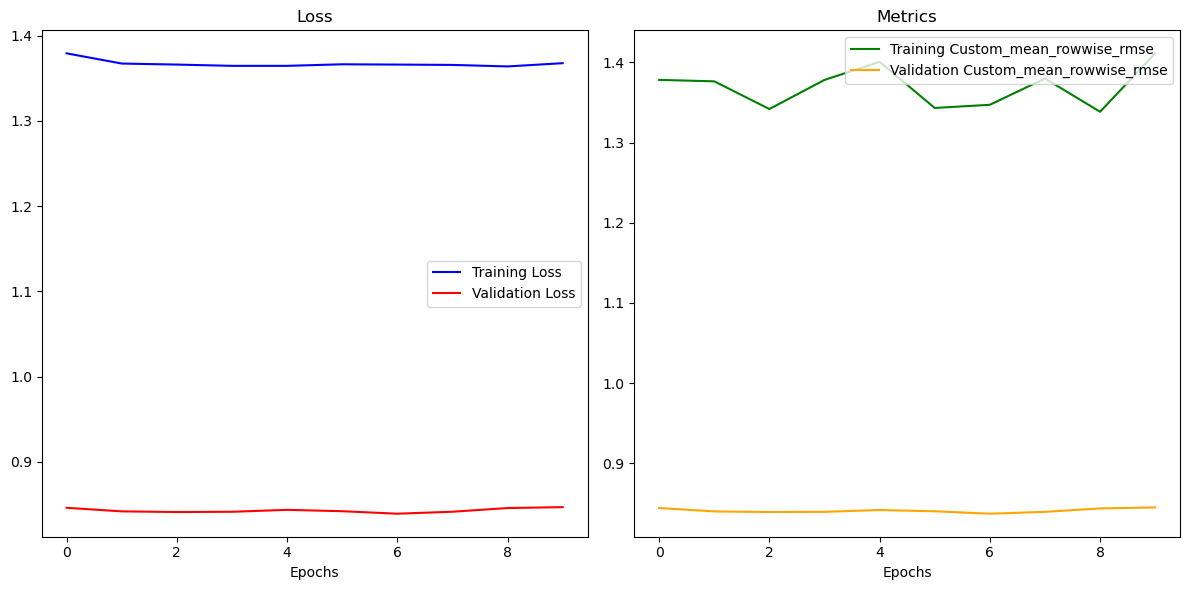

In [70]:
plot_training_history(history_1, metrics=["custom_mean_rowwise_rmse"])